# Section 1: Problem #

The dataset I am going to use is "[Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)" from Kaggle. One of the problems is to perform sentiment analysis and classification based on the reviews from users. Another one is to recommend new products to the users based on their past rating and other users' rating with similar tastes.

From a broader perspective, there is a need for an intelligent classifier based on text information process. There most common example we have seen everyday is probably the spam or junk mail filter in the email system which is telling you whether the email is a junk mail or not. This is a typical binary classifier. Another one is the Webpage classifcation based on its content. For example, when browsing [Google News](http://news.google.com.au/), we can see the news from different categories like "Business", "Technology", "Sports", etc.. It is the intelligent machine learning applications which automatically classify each webpage into different categories. This is an example of multiclass classifier.

Recommender system has been widely used in recent years. It has become a important aspect for companies with marketing strategy targetting to tailor for each customer's preferences and interests. Personalisation is now transforming and improving customer experience for all kinds of businesses, for example, making product recommendation for online shopping, suggesting movies, music and news.The most famous one is [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) to compete for the best collaborative filtering algorithm.


**The problems of interest I am going to explore are: **

* Which product has the most positive reviews and which has the most negative reviews?
* Who are the users tending to have more negative reviews?
* Which are the important words that lead to a positive or negative reviews?
* How to recommend new fine foods to the users based on  other users' reviews?
* Besides Accuracy, what are the other evaluation metrics to consider for classification problem?


# Section 2: Data

The dataset is downloaded from [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews), it was originally published on [SNAP](http://snap.stanford.edu/data/web-FineFoods.html). 

The dataset contains around 500,000 food reviews from Amazon with a period between 1999 and 2012. It is a single csv file about 286 MB which includes productID, userID, rating of the product, review summary and text of details.

The dataset is pretty clean. There is no missing data for each feature/column. However, it is required to do some transformation and cleaning to build up a user product matrix and to process the text data of the reviews.

In [15]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from scipy.sparse import lil_matrix
import string
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
import re
%matplotlib inline

In [2]:
food_reviews = pd.read_csv('./amazon-fine-foods/Reviews.csv')
food_reviews[:3]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# food_reviews.head()
food_reviews.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [4]:
food_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
num_products = len(food_reviews['ProductId'].unique())
num_users = len(food_reviews['UserId'].unique())
print("There are {0} products reviewed by {1} users with total {2} ratings.".format(num_products, num_users, len(food_reviews)))

There are 74258 products reviewed by 256059 users with total 568454 ratings.


## Rating distribution

In [6]:
rating_count = food_reviews['Score'].value_counts(sort=False)
# rating_count
rating_pct = food_reviews[food_reviews['Score'] != 3]['Score'].value_counts(normalize=True, sort=False)
# rating_pct
neg_pct = rating_pct[[1, 2]].sum()
pos_pct = rating_pct[[4, 5]].sum()
print('The accuracy of majority class classifier is {0:2.2%}'.format(pos_pct))
ratings = Series([neg_pct*100, pos_pct*100], index=['negative', 'positive'])

The accuracy of majority class classifier is 84.40%


This is an imbalanced dataset biased towards 5 in terms of Score (or rating). If we are going to build a sentiment classifier, we should use the **majority class classifier ** as the baseline model to evaluate our classifier. We will ignore the reviews with *Score = 3* as they tend to have a neutral sentiment. *Score = [1,2]* will be negative rating and *Score = [4,5]* will be positive rating. So the **majority class classifier ** will be positive rating.

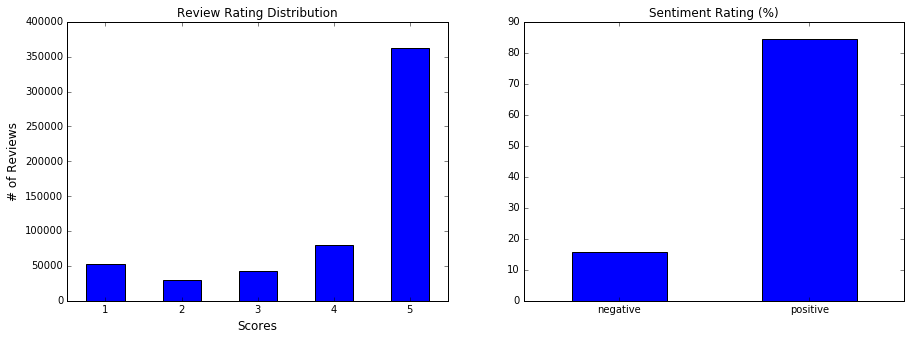

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
rating_count.plot(kind='bar', title='Review Rating Distribution', rot=0)
plt.xlabel('Scores', {'fontsize': 'large'})
plt.ylabel('# of Reviews', {'fontsize': 'large'})
plt.subplot(122)
ratings.plot(kind='bar', title='Sentiment Rating (%)', rot=0)
plt.show()

## What is the ratings for the highly reviewed products?
First we need to check the mean rating for each product. And we will get the products will reviews in descending order. We can then check the mean Scores for the top 10 reviewed products.

In [8]:
ratings_mean = food_reviews.pivot_table('Score', index='ProductId', aggfunc='mean')
ratings_mean[:5]

ProductId
0006641040    4.351351
141278509X    5.000000
2734888454    3.500000
2841233731    5.000000
7310172001    4.751445
Name: Score, dtype: float64

In [9]:
products_cnt = food_reviews['ProductId'].value_counts()
products_cnt[:5]

B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
Name: ProductId, dtype: int64

In [10]:
products_top10 = products_cnt.index[:10]
products_top10
ratings_mean.ix[products_top10]

B007JFMH8M    4.582694
B0026RQTGE    4.588608
B002QWHJOU    4.588608
B002QWP89S    4.588608
B002QWP8H0    4.588608
B003B3OOPA    4.739968
B001EO5Q64    4.746032
B001RVFEP2    4.310284
B001RVFERK    4.310284
B0013NUGDE    4.310284
Name: Score, dtype: float64

## Cleaning and transforming text data ##
We are going to use the review text as the features of sentiment classifier model. We need to clean and transform the text data with the following process:

* Changing the characters to lower case
* Removing special words (i.e. HTML tags) punctuation
* Tokenisation
* Counting the words

The result is a dict of word count for each row.

In [11]:
text = """I've bought these for my husband who is currently overseas. He loves these, and apparently his staff 
likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price.
<a href=""http://www.amazon.com/gp/product/B001GVISJM"">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>"""
# print(nltk.tokenize.wordpunct_tokenize(text.lower()))
# print(nltk.tokenize.TreebankWordTokenizer().tokenize(text.lower()))
def word_count(text):
    text = str(text)    # convert to string
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    intab = string.punctuation
    outtab = " " * len(string.punctuation)
    transtab = str.maketrans(intab, outtab)
    text = text.translate(transtab)
    tokens = nltk.tokenize.word_tokenize(text)
    res = Counter(tokens)
    return res
    
# word_count(text)

In [12]:
food_reviews['wordCount'] = food_reviews['Summary'].apply(word_count)
food_reviews[['Summary', 'wordCount']][:5]

,Summary,wordCount
0,Good Quality Dog Food,"{'dog': 1, 'good': 1, 'food': 1, 'quality': 1}"
1,Not as Advertised,"{'advertised': 1, 'as': 1, 'not': 1}"
2,"""Delight"" says it all","{'it': 1, 'all': 1, 'delight': 1, 'says': 1}"
3,Cough Medicine,"{'medicine': 1, 'cough': 1}"
4,Great taffy,"{'great': 1, 'taffy': 1}"


### What are the frequent words appearing in positive reviews?

It is required an extra step to remove the common words by using NLTK stopwords set.

In [29]:
stopwords = nltk.corpus.stopwords.words('english')
positive_words = defaultdict(int)
negative_words = defaultdict(int)
for words in food_reviews[food_reviews['Score'] > 3]['wordCount']:
    for w, c in words.items():
        if w not in stopwords:
            positive_words[w] += c
        
for words in food_reviews[food_reviews['Score'] < 3]['wordCount']:
    for w, c in words.items():
        if w not in stopwords:
            negative_words[w] += c        

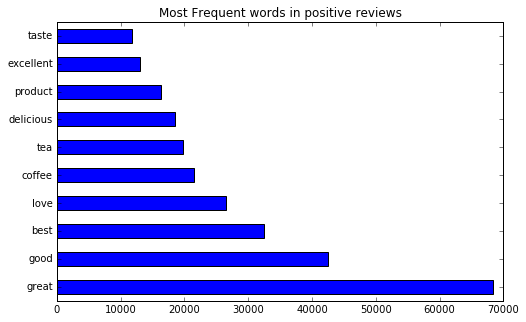

In [43]:
# len(negative_words)
# sorted(negative_words, key=lambda x: x.items()[1], reverse=True)[:10]
# pos_words_series.plot(kind='barh', title='Most Frequent words in positive reviews')
pos_words_series = Series(positive_words)
plt.figure(figsize=(8,5))
pos_words_series.sort_values(ascending=False)[:10].plot(kind='barh', title='Most Frequent words in positive reviews')

## User-Product-Rating Matrix
I am trying to use Pandas pivot_table to generate the matrix with the dimension of 74258 (products) x 256059 (users). However, I encounter `index out of bound` error. Here I will use a subset (20,000) of reviews to construct the matrix.

The result is a sparse matrix. For any cell that are missing data (i.e. the user didn't rate the product), we are going to set to 0.

**Will explore to use sparse matrix to implement the rating matrix in stage 2 **

In [13]:
user_product_rating = food_reviews[:20000].pivot_table(values='Score', index='UserId', columns='ProductId')
user_product_rating = user_product_rating.fillna(value=0)
user_product_rating[:10]

ProductId,B00002NCJC,B00002Z754,B00005V3DC,B000084DVR,B000084E1U,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,...,B0093NIWVO,B00959DMWK,B00961CUXO,B0096E5196,B009AVDFCK,B009D668KS,B009HINRX8,B009KP6HBM,B009UOFU20,B009WSNWC4
UserId,,,,,,,,,,,,,,,,,,,,,
A10012K7DF3SBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1001TYW5FZYD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1001WVQ2UV7DD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1003ACBU13X6E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1004703RC79J9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10080F3BO83XV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1008DPSP6KC9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1011I2PCI4K8B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
user_product_rating[user_product_rating.ix[:, 0] != 0]
# user_product_rating.ix[, 0]

ProductId,B00002NCJC,B00002Z754,B00005V3DC,B000084DVR,B000084E1U,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,...,B0093NIWVO,B00959DMWK,B00961CUXO,B0096E5196,B009AVDFCK,B009D668KS,B009HINRX8,B009KP6HBM,B009UOFU20,B009WSNWC4
UserId,,,,,,,,,,,,,,,,,,,,,
A13RRPGE79XFFH,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A196AJHU9EASJN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# explore scipy sparse matrix
rating_matrix = lil_matrix((256059, 74258))

# Section 3: Proposal

I am going to build a sentiment classifier using logistic regreesion model with bag-of-words as features. I will also explore other text analysis options like TF-IDF, bigram for the feature engineering. Based on the weights (coefficients) of the model, it will reveal the positive and negative word sets.

For recommender system, I will explore [Collaborative filtering][CF] approach to recommend products based on the similar preferences of different users. I need to investigate to utilise sparse matrix (from numpy and scipy) and how to solve sparsity problem.

For classification model, the baseline is the majority class classifier. Moreover, we will evaluate metrics like the confusion matrix, Precision, Recall, F-score. 

For recommender system, we need to evaluate the trade-off of Precision and Recall or precision-recall curve. 

[CF]:https://en.wikipedia.org/wiki/Collaborative_filtering